In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import simpson 

In [5]:
#leer el archivo Surface_Br.dat

data = pd.read_csv('Surface_Br.dat', delim_whitespace=True, header=None, names=['Radius[arcsec]', 'Brightness[mag/arcsec^2]'])
data.head()

/tmp/ipykernel_5907/980975307.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('Surface_Br.dat', delim_whitespace=True, header=None, names=['Radius[arcsec]', 'Brightness[mag/arcsec^2]'])


,Radius[arcsec],Brightness[mag/arcsec^2]
0,0.00,15.52
1,0.00,15.60
2,0.00,15.60
3,0.02,15.59
4,0.03,15.66


In [14]:
#queremos estimar la distribucion volumetrica de brillo j(r) a partir de la distribucion superficial I(R)
#usamos la inversion de Abel

def abel_inversion(R, I):
    """
    Calcula la inversión de Abel para obtener j(r) desde I(R).
    """
    # La inversión de Abel requiere una derivada de I.
    # Usamos np.gradient para la derivada y la interpolamos para evaluarla en cualquier R.
    dIdR = np.gradient(I, R)
    dIdR_interp = lambda x: np.interp(x, R, dIdR)
    
    j = np.zeros_like(R)
    for i, r in enumerate(R):
        # Integramos desde r hasta el radio máximo.
        # Se añade un valor pequeño al límite inferior para evitar división por cero.
        R_prime = np.linspace(r + 1e-6, R.max(), 500)
        integrand = dIdR_interp(R_prime) / np.sqrt(R_prime**2 - r**2)
        
        integral = simpson(integrand, R_prime)
        j[i] = -1/np.pi * integral
        
    return j

In [15]:
#aplico a los datos disponibles

R = data['Radius[arcsec]'].values
I_mag = data['Brightness[mag/arcsec^2]'].values
I = 10**(-0.4 * I_mag)  # Convertir de mag/arcsec^2 a unidades lineales 

j = abel_inversion(R, I) 
j_nl = abel_inversion(R,I_mag)

/home/mariana/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/mariana/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1309: RuntimeWarning: invalid value encountered in divide
  a = -(dx2) / (dx1 * (dx1 + dx2))
/home/mariana/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/mariana/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1310: RuntimeWarning: invalid value encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/mariana/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1311: RuntimeWarning: invalid value encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/home/mariana/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:1317: RuntimeWarning: invalid value encountered in

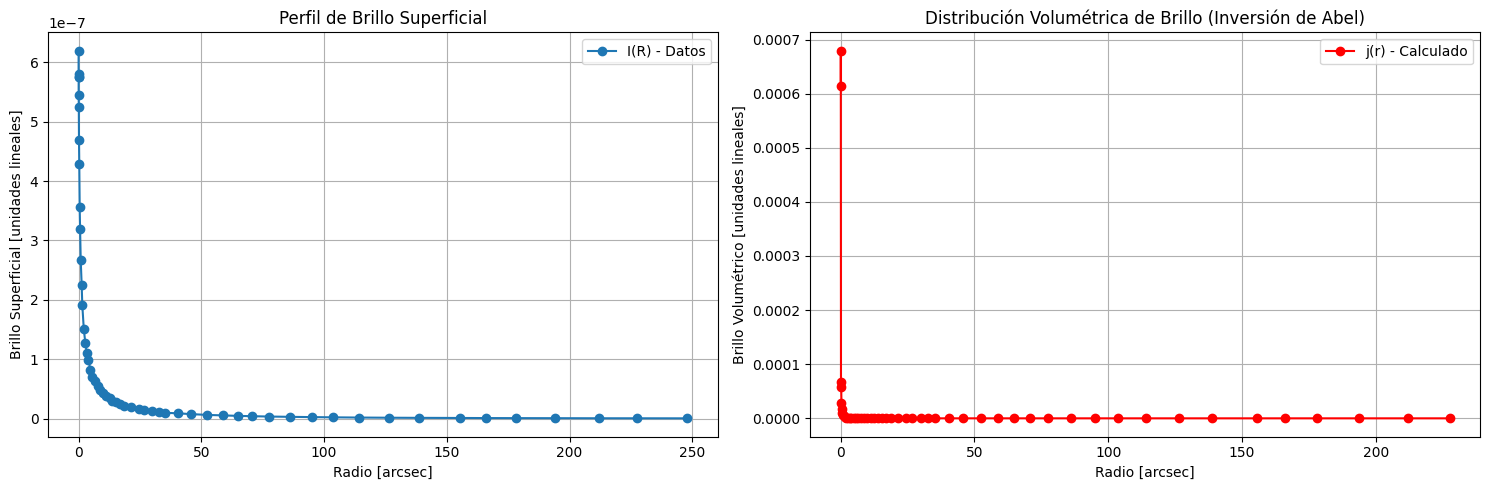

In [16]:
#ahora, grafico los resultados
plt.figure(figsize=(15, 5))

# Grafico 1: Perfil de Brillo Superficial (lineal)
plt.subplot(1, 2, 1)
plt.plot(R, I, 'o-', label='I(R) - Datos')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Superficial [unidades lineales]')
plt.title('Perfil de Brillo Superficial')
plt.legend()
plt.grid(True)

# Grafico 2: Distribución Volumétrica de Brillo
plt.subplot(1, 2, 2)
plt.plot(R, j, 'o-', color='r', label='j(r) - Calculado')
plt.xlabel('Radio [arcsec]')
plt.ylabel('Brillo Volumétrico [unidades lineales]')
plt.title('Distribución Volumétrica de Brillo (Inversión de Abel)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.integrate import cumulative_trapezoid

# Asumiendo una razón masa-luz (Upsilon) constante, la densidad de masa rho(r) es proporcional a j(r).
# rho(r) = Upsilon * j(r)
# Como no conocemos Upsilon, trabajaremos con rho(r) / Upsilon = j(r).
rho_sobre_Upsilon = j

# Calcular la masa acumulada M(r) integrando la densidad de masa.
# M(r) = 4 * pi * integral(r'^2 * rho(r')) dr' de 0 a r
# M(r) / Upsilon = 4 * pi * integral(r'^2 * j(r')) dr'
integrand = R**2 * j
# Usamos cumulative_trapezoid para la integración acumulada.
# Se añade un 0 al principio porque la función devuelve un array de N-1 elementos.
M_sobre_Upsilon = 4 * np.pi * np.concatenate(([0], cumulative_trapezoid(integrand, R)))


# Graficar la densidad de masa y la masa acumulada
plt.figure(figsize=(15, 5))

# Grafico 1: Densidad de Masa (en unidades de Upsilon)
plt.subplot(1, 2, 1)
plt.plot(R, rho_sobre_Upsilon, 'o-', label=r'$\rho(r) / \Upsilon$')
plt.xlabel('Radio [arcsec]')
plt.ylabel(r'Densidad de Masa / $\Upsilon$')
plt.title('Perfil de Densidad de Masa')
plt.legend()
plt.grid(True)

# Grafico 2: Masa Acumulada (en unidades de Upsilon)
plt.subplot(1, 2, 2)
plt.plot(R, M_sobre_Upsilon, 'o-', color='g', label=r'$M(r) / \Upsilon$')
plt.xlabel('Radio [arcsec]')
plt.ylabel(r'Masa Acumulada / $\Upsilon$')
plt.title('Masa Acumulada vs. Radio')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()